## Lab 3 Part 3: PPG Analysis

In this part, we will examine the recovery time for human heart rate using our PPG sensor. We for a run for 20 minutes; after this workout, we immediately measured the heart rate over the next five minutes (sitting very still will gave us a good signal from the PPG, and also allowed our HR to recover as quickly as possible).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, get_window, welch, butter, filtfilt
from scipy.fft import fft, fftfreq
from scipy.optimize import curve_fit
import csv

We plot our HR as a function of time.

In [120]:
# Constants
f_s = 400  # Hz
min_hr = 30  # Minimum heart rate in beats per minute

# Imports
ppg_path = '/Users/egeturan/Documents/Sensing/SmartphoneSensors292S/ee292s/lab3/ecg_data_5m_postexertion_patricia.csv'

def parse_data(file_path):
    # Initialize lists to store the time and ecg_signal data
    time = []
    ecg_signal = []

    # Open and read the CSV file
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row

        for row in reader:
            # Append the parsed time and ecg_signal values
            time.append(float(row[0]))
            ecg_signal.append(float(row[1]))

    # Convert the lists to NumPy arrays
    time_array = np.array(time) - 64.84
    ecg_signal_array = np.array(ecg_signal)

    return time_array, ecg_signal_array

In [121]:
time, ppg = parse_data(ppg_path)

# Define minimum time difference between peaks (based on heart rate)
min_time_diff = min_hr / 60  # Minimum time difference in seconds
min_sample_diff = int(min_time_diff * f_s)  # Convert to sample indices

# Find all peaks
peaks, properties = find_peaks(ppg, distance=min_sample_diff)

print("ppg:", ppg)

ppg: [2.43675499 2.45856255 2.46100395 ... 2.53913731 2.54259617 2.53676922]


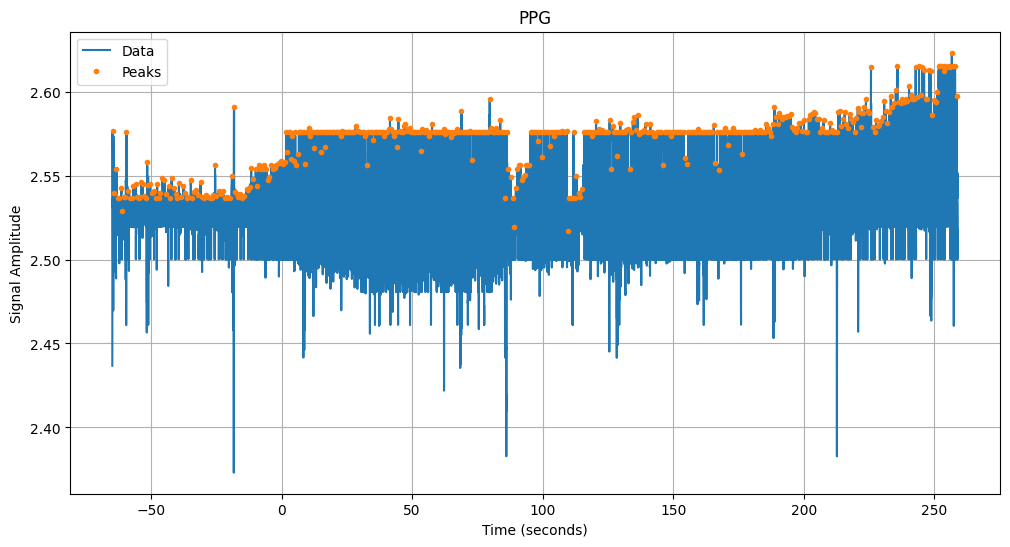

In [122]:
# Plot the full data
plt.figure(figsize=(12, 6))
plt.plot(time, ppg, label="Data")
plt.plot(time[peaks], ppg[peaks], ".", label="Peaks")  # Mark peaks with dots

# Add labels, legend, and title
plt.title("PPG")
plt.xlabel("Time (seconds)")
plt.ylabel("Signal Amplitude")
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [123]:
# Calculate heart rate from peaks
if len(peaks) > 1:
    peak_intervals = np.diff(peaks)  # Differences between consecutive peaks (in samples)
    avg_peak_interval = np.mean(peak_intervals)  # Average interval in samples
    avg_heart_rate = (60 * f_s) / avg_peak_interval  # Convert to beats per minute (BPM)
else:
    avg_heart_rate = 0  # Not enough peaks to calculate heart rate

print(f"Cumulative average Heart Rate: {avg_heart_rate:.2f} BPM")

Cumulative average Heart Rate: 93.81 BPM


Now, we plot our HR as a function of time. Smoothing the data using a moving average filter (deciding on the averaging length based on how noisy the data is). 

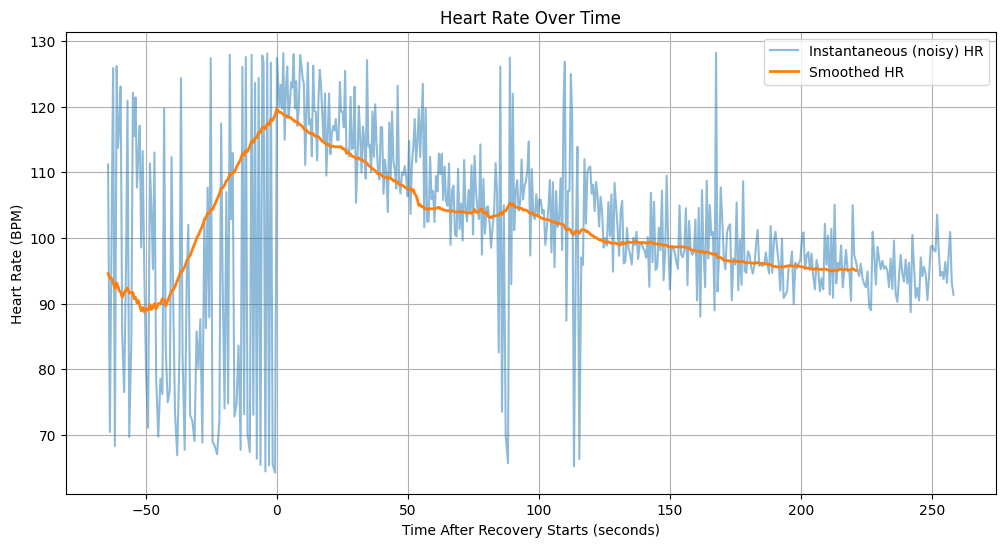

In [124]:
# Calculate the time of each peak
peak_times = time[peaks]

# Calculate instantaneous heart rates (in BPM) from consecutive peak intervals
# Then, moving-average this
if len(peak_times) > 1:
    peak_intervals = np.diff(peak_times)  # Differences between consecutive peaks (in seconds)
    instantaneous_hr = 60 / peak_intervals  # Convert to BPM

    # Associate each instantaneous HR with the midpoint of the peak intervals
    hr_times = peak_times[:-1] + peak_intervals / 2

    # Apply a moving average filter to smooth the instantaneous heart rate
    avg_window_size = 60  # Adjust the window size based on noise level
    smoothed_hr = np.convolve(instantaneous_hr, np.ones(avg_window_size) / avg_window_size, mode='valid')

    # Adjust the time axis for the smoothed HR
    smoothed_hr_times = hr_times[:len(smoothed_hr)]
else:
    instantaneous_hr = []
    smoothed_hr = []
    smoothed_hr_times = []
    print("Not enough peaks detected to calculate instantaneous heart rate.")

# Plot the heart rate as a function of time
plt.figure(figsize=(12, 6))
if len(smoothed_hr) > 0:  # Check if the smoothed_hr array has any values
    plt.plot(hr_times, instantaneous_hr, label="Instantaneous (noisy) HR", alpha=0.5)
    plt.plot(smoothed_hr_times, smoothed_hr, label="Smoothed HR", linewidth=2)
    plt.title("Heart Rate Over Time")
    plt.xlabel("Time After Recovery Starts (seconds)")
    plt.ylabel("Heart Rate (BPM)")
    plt.legend()
else:
    plt.title("Heart Rate Over Time - No HR Calculated")
plt.grid(True)
plt.show()


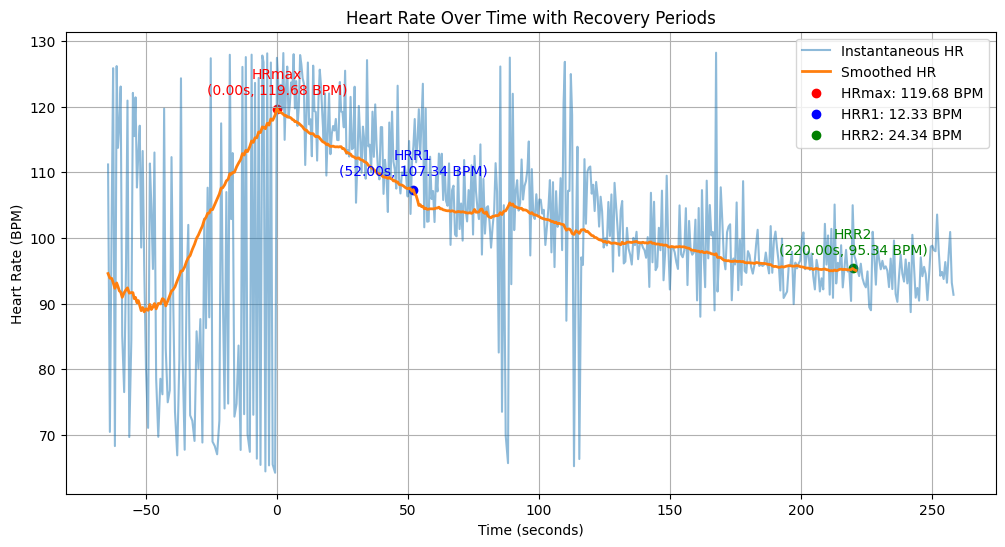

HRmax: 119.68 BPM at 0.00 seconds
HRR1: 12.33 BPM (52 seconds after HRmax)
HRR2: 24.34 BPM (220 seconds after HRmax)


In [125]:
# Find HRmax and its time
if len(smoothed_hr) > 0:
    hr_max_idx = np.argmax(smoothed_hr)  # Index of maximum heart rate
    hr_max_time = smoothed_hr_times[hr_max_idx]  # Time of HRmax
    hr_max_value = smoothed_hr[hr_max_idx]  # HRmax value

    # Calculate HRR1 (during first recovery period)
    time_1_sec = hr_max_time + 52
    hr_1_idx = np.argmin(np.abs(smoothed_hr_times - time_1_sec))  # Closest index to about 52 seconds after HRmax
    hr_1_value = smoothed_hr[hr_1_idx]
    hrr1 = hr_max_value - hr_1_value

    # Calculate HRR2 (during second recovery period)
    time_2_sec = hr_max_time + 220
    hr_2_idx = np.argmin(np.abs(smoothed_hr_times - time_2_sec))  # Closest index to about 210 seconds after HRmax
    hr_2_value = smoothed_hr[hr_2_idx]
    hrr2 = hr_max_value - hr_2_value

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(hr_times, instantaneous_hr, label="Instantaneous HR", alpha=0.5)
    plt.plot(smoothed_hr_times, smoothed_hr, label="Smoothed HR", linewidth=2)

    # Mark HRmax
    plt.scatter(hr_max_time, hr_max_value, color='red', label=f"HRmax: {hr_max_value:.2f} BPM")
    plt.annotate(f"HRmax\n({hr_max_time:.2f}s, {hr_max_value:.2f} BPM)",
                 (hr_max_time, hr_max_value),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    # Mark HRR1
    plt.scatter(time_1_sec, hr_1_value, color='blue', label=f"HRR1: {hrr1:.2f} BPM")
    plt.annotate(f"HRR1\n({time_1_sec:.2f}s, {hr_1_value:.2f} BPM)",
                 (time_1_sec, hr_1_value),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    # Mark HRR2
    plt.scatter(time_2_sec, hr_2_value, color='green', label=f"HRR2: {hrr2:.2f} BPM")
    plt.annotate(f"HRR2\n({time_2_sec:.2f}s, {hr_2_value:.2f} BPM)",
                 (time_2_sec, hr_2_value),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='green')

    # Add labels, legend, and title
    plt.title("Heart Rate Over Time with Recovery Periods")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Heart Rate (BPM)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data to calculate HRmax, HRR1, or HRR2.")

print(f"HRmax: {hr_max_value:.2f} BPM at {hr_max_time:.2f} seconds")
print(f"HRR1: {hrr1:.2f} BPM (52 seconds after HRmax)")
print(f"HRR2: {hrr2:.2f} BPM (220 seconds after HRmax)")


Let's also include lines in each of the two recovery zones to show their average rates of recovery.

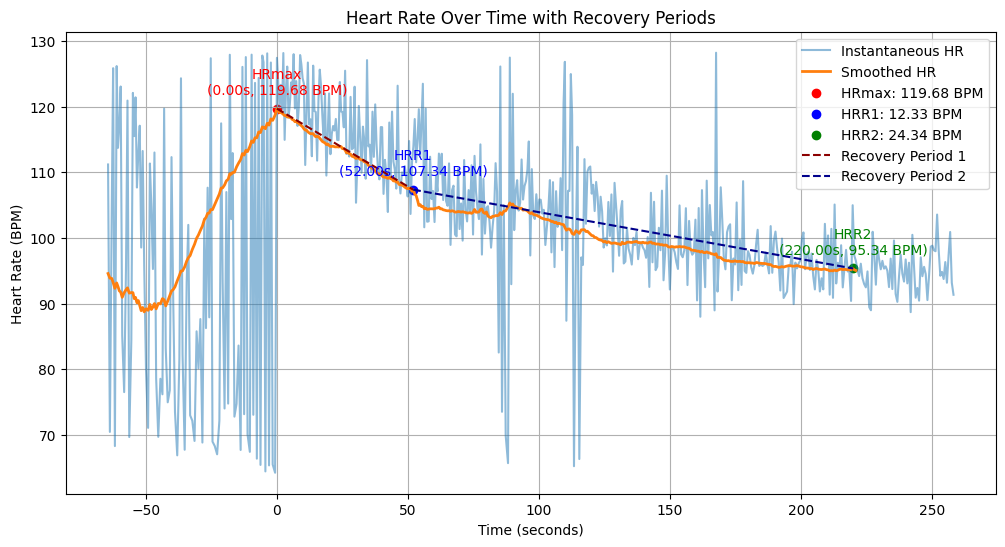

In [126]:
# Find HRmax and its time
if len(smoothed_hr) > 0:
    hr_max_idx = np.argmax(smoothed_hr)  # Index of maximum heart rate
    hr_max_time = smoothed_hr_times[hr_max_idx]  # Time of HRmax
    hr_max_value = smoothed_hr[hr_max_idx]  # HRmax value

    # Calculate HRR1 (during first recovery period)
    time_1_sec = hr_max_time + 52
    hr_1_idx = np.argmin(np.abs(smoothed_hr_times - time_1_sec))  # Closest index to 52 seconds after HRmax
    hr_1_value = smoothed_hr[hr_1_idx]
    hrr1 = hr_max_value - hr_1_value

    # Calculate HRR2 (during second recovery period)
    time_2_sec = hr_max_time + 220
    hr_2_idx = np.argmin(np.abs(smoothed_hr_times - time_2_sec))  # Closest index to 220 seconds after HRmax
    hr_2_value = smoothed_hr[hr_2_idx]
    hrr2 = hr_max_value - hr_2_value

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(hr_times, instantaneous_hr, label="Instantaneous HR", alpha=0.5)
    plt.plot(smoothed_hr_times, smoothed_hr, label="Smoothed HR", linewidth=2)

    # Mark HRmax
    plt.scatter(hr_max_time, hr_max_value, color='red', label=f"HRmax: {hr_max_value:.2f} BPM")
    plt.annotate(f"HRmax\n({hr_max_time:.2f}s, {hr_max_value:.2f} BPM)",
                 (hr_max_time, hr_max_value),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='red')

    # Mark HRR1
    plt.scatter(time_1_sec, hr_1_value, color='blue', label=f"HRR1: {hrr1:.2f} BPM")
    plt.annotate(f"HRR1\n({time_1_sec:.2f}s, {hr_1_value:.2f} BPM)",
                 (time_1_sec, hr_1_value),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='blue')

    # Mark HRR2
    plt.scatter(time_2_sec, hr_2_value, color='green', label=f"HRR2: {hrr2:.2f} BPM")
    plt.annotate(f"HRR2\n({time_2_sec:.2f}s, {hr_2_value:.2f} BPM)",
                 (time_2_sec, hr_2_value),
                 textcoords="offset points", xytext=(0, 10), ha='center', color='green')

    # Add lines
    plt.plot([hr_max_time, time_1_sec], [hr_max_value, hr_1_value], color='darkred', linestyle='--', label="Recovery Period 1")
    plt.plot([time_1_sec, time_2_sec], [hr_1_value, hr_2_value], color='darkblue', linestyle='--', label="Recovery Period 2")

    # Add labels, legend, and title
    plt.title("Heart Rate Over Time with Recovery Periods")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Heart Rate (BPM)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data to calculate HRmax, HRR1, or HRR2.")


Now, we can calculate the recovery time constant.

## HR(t) = HR∞ + (HRmax - HR∞) • e^(t/T)

The recovery time constant (τ) represents how quickly the heart rate decreases after reaching its maximum value. It can be calculated by fitting the exponential decay model we have written above.

In [127]:
# Exponential decay model
def recovery_model(t, hr_inf, tau):
    return hr_inf + (hr_max_value - hr_inf) * np.exp(-t / tau)

# Define the recovery period data (after HRmax)
if len(smoothed_hr) > 0:
    recovery_mask = smoothed_hr_times > hr_max_time  # Data after HRmax
    recovery_times = smoothed_hr_times[recovery_mask] - hr_max_time  # Relative time after HRmax
    recovery_hr = smoothed_hr[recovery_mask]  # Heart rate during recovery

    if len(recovery_hr) > 2:  # Ensure enough data for fitting
        # Initial guesses: HR_inf (minimum HR during recovery) and tau (arbitrary positive value)
        hr_inf_guess = np.min(recovery_hr)
        tau_guess = 50  # Initial guess for time constant

        # Fit the model
        popt, pcov = curve_fit(recovery_model, recovery_times, recovery_hr, p0=[hr_inf_guess, tau_guess])
        hr_inf, tau = popt

        # Plot the data and fit
        plt.figure(figsize=(12, 6))
        plt.plot(recovery_times, recovery_hr, 'o', label="Recovery Data", alpha=0.6)
        plt.plot(recovery_times, recovery_model(recovery_times, *popt), label=f"Fit: HR_inf={hr_inf:.2f}, Tau={tau:.2f}s", color='red')

        # Add labels and legend
        plt.title("Heart Rate Recovery and Time Constant Fit")
        plt.xlabel("Time After HRmax (seconds)")
        plt.ylabel("Heart Rate (BPM)")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Estimated Recovery Time Constant (Tau): {tau:.2f} seconds")
        print(f"Asymptotic Heart Rate (HR_inf): {hr_inf:.2f} BPM")
    else:
        print("Not enough data points in the recovery period to fit the model.")
else:
    print("Not enough data to calculate the recovery time constant.")

NameError: name 'curve_fit' is not defined